In [4]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import re


# 1. Przetwarzanie obrazów

### Wczytanie obrazów

In [5]:
# source: https://blogs.kingston.ac.uk/retinal/chasedb1/

imageFolder = "images"
imageNames = os.listdir(imageFolder)
imageNames.sort()
images = {}
for filename in imageNames:
    img = cv2.imread(imageFolder + "/" +  filename)
    images[filename] = img

manualLabeledImageFolder = "manual1"
labeledImageNames = os.listdir(manualLabeledImageFolder)
labeledImageNames.sort()
manualVessels = {}
for filename in labeledImageNames:
    img  = cv2.imread(manualLabeledImageFolder + "/" + filename)
    manualVessels[filename] = img
print(images.keys())
print(manualVessels.keys())



    

dict_keys(['01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', '05_h.jpg', '06_h.jpg', '07_h.jpg', '08_h.jpg', '09_h.jpg', '10_h.jpg', '11_h.jpg', '12_h.jpg', '13_h.jpg', '14_h.jpg', '15_h.jpg'])
dict_keys(['01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', '05_h.jpg', '06_h.jpg', '07_h.jpg', '08_h.jpg', '09_h.jpg', '10_h.jpg', '11_h.jpg', '12_h.jpg', '13_h.jpg', '14_h.jpg', '15_h.jpg'])


### Przykładowe obrazy

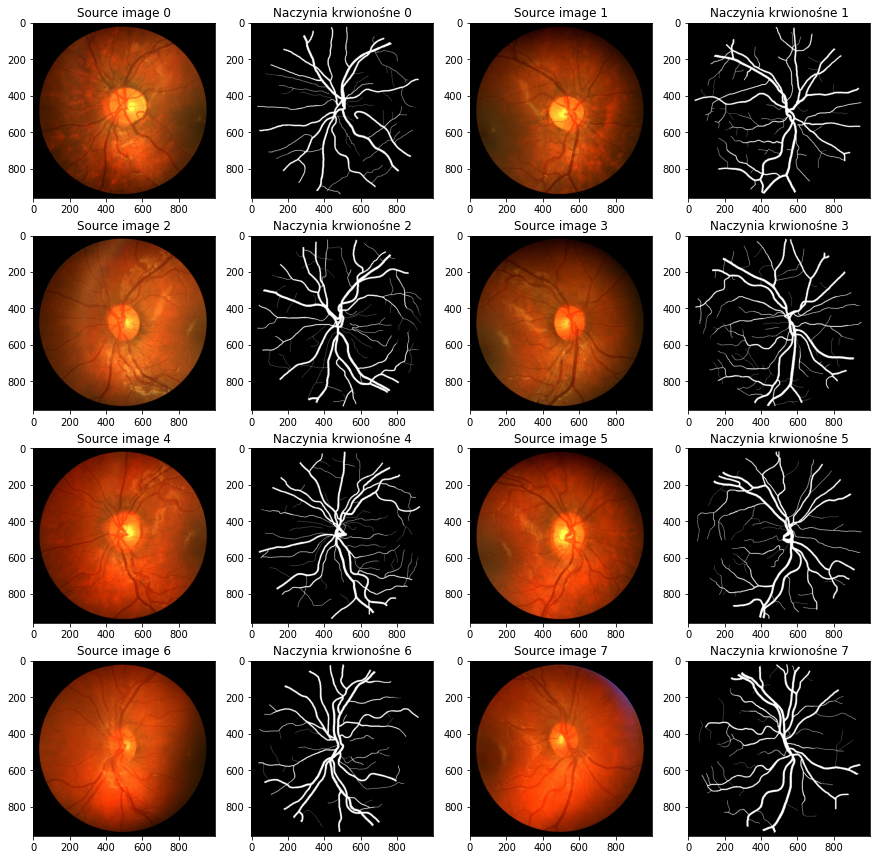

In [6]:
figure = plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(0, columns*rows):
    figure.add_subplot(rows, columns, i+1)
    if (i+1)%2:
        img = list(images.values())[int(i/2)]
        plt.title(f"Source image {int(i/2)}")
        plt.imshow(img[:,:,::-1])
    else:
        img = list(manualVessels.values())[int(i/2)]
        plt.title(f"Naczynia krwionośne {int(i/2)}")
        plt.imshow(img, cmap='gray')
plt.show()

### Wybór najlepszego kanału koloru

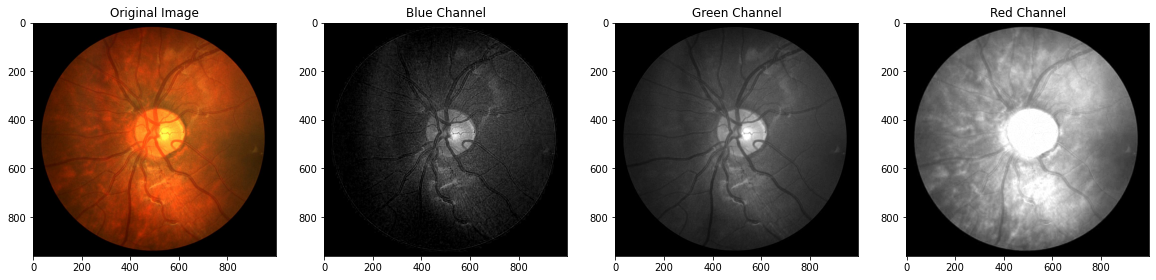

In [7]:
img = images['01_h.jpg']
imgBlueChannel = img[:,:,0]
imgGreenChannel = img[:,:,1]
imgRedChannel = img[:,:,2]

plt.figure(figsize=(20,12))
plt.subplot(141)
plt.imshow(img[:,:,::-1]);
plt.title("Original Image")
plt.subplot(142)
plt.imshow(imgBlueChannel, cmap='gray');
plt.title("Blue Channel")
plt.subplot(143)
plt.imshow(imgGreenChannel, cmap='gray');
plt.title("Green Channel")
plt.subplot(144)
plt.imshow(imgRedChannel, cmap='gray');
plt.title("Red Channel");

### Zwiększenie kontrastu metodą wyrównania histogramu
- od tego momentu przetwarzamy już tylko kanał zielony

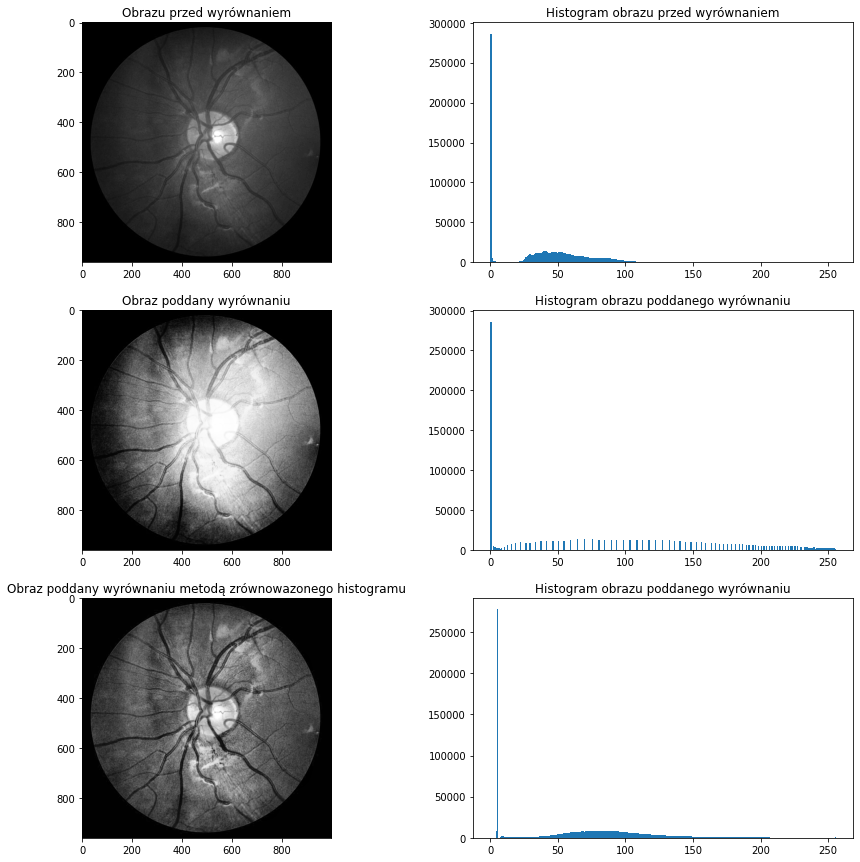

In [8]:
imgEqualized = cv2.equalizeHist(imgGreenChannel)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
imgEqualizedCLAHE = clahe.apply(imgGreenChannel)

fig = plt.figure(figsize=(15, 15))

plt.subplot(321)
plt.imshow(imgGreenChannel, cmap='gray')
plt.title("Obrazu przed wyrównaniem")
plt.subplot(322)
plt.hist(imgGreenChannel.ravel(),256,[0,256])
plt.title("Histogram obrazu przed wyrównaniem")

plt.subplot(323)
plt.imshow(imgEqualized, cmap='gray')
plt.title("Obraz poddany wyrównaniu")
plt.subplot(324)
plt.hist(imgEqualized.ravel(),256,[0,256])
plt.title("Histogram obrazu poddanego wyrównaniu")

plt.subplot(325)
plt.imshow(imgEqualizedCLAHE, cmap='gray')
plt.title("Obraz poddany wyrównaniu metodą zrównowazonego histogramu")
plt.subplot(326)
plt.hist(imgEqualizedCLAHE.ravel(),256,[0,256])
plt.title("Histogram obrazu poddanego wyrównaniu")

plt.show()

Text(0.5, 1.0, 'Histogram tła metoda KNN')

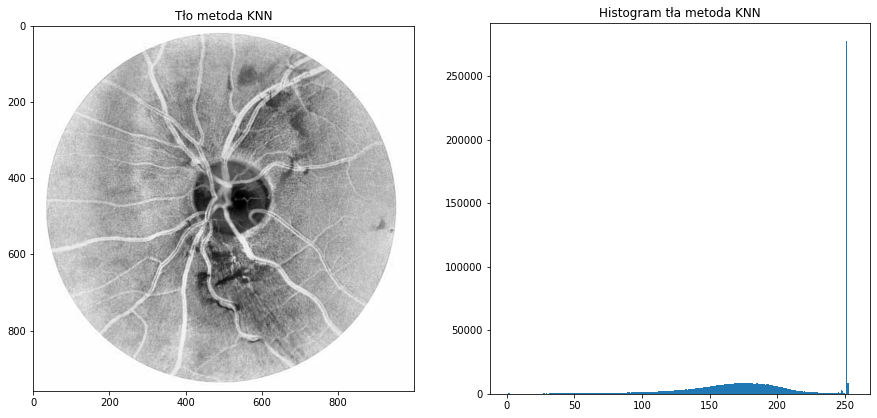

In [9]:
backgroundSubstractorKNN = cv2.createBackgroundSubtractorKNN()
backgroundSubstractorMOG2 = cv2.createBackgroundSubtractorMOG2(0, varThreshold=0, detectShadows=False)
imgBackgroundKNN = backgroundSubstractorKNN.apply(imgEqualizedCLAHE)
imgBackgroundMOG2 = backgroundSubstractorMOG2.apply(imgEqualizedCLAHE)


imgBackgroundKNN = backgroundSubstractorKNN.apply(imgEqualizedCLAHE.copy())
imgKNNSubtracted = imgEqualizedCLAHE * imgBackgroundKNN
fig = plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.imshow(imgKNNSubtracted, cmap='gray')
plt.title("Tło metoda KNN")
plt.subplot(222)
plt.hist(imgKNNSubtracted.ravel(),256,[0,256])
plt.title("Histogram tła metoda KNN")



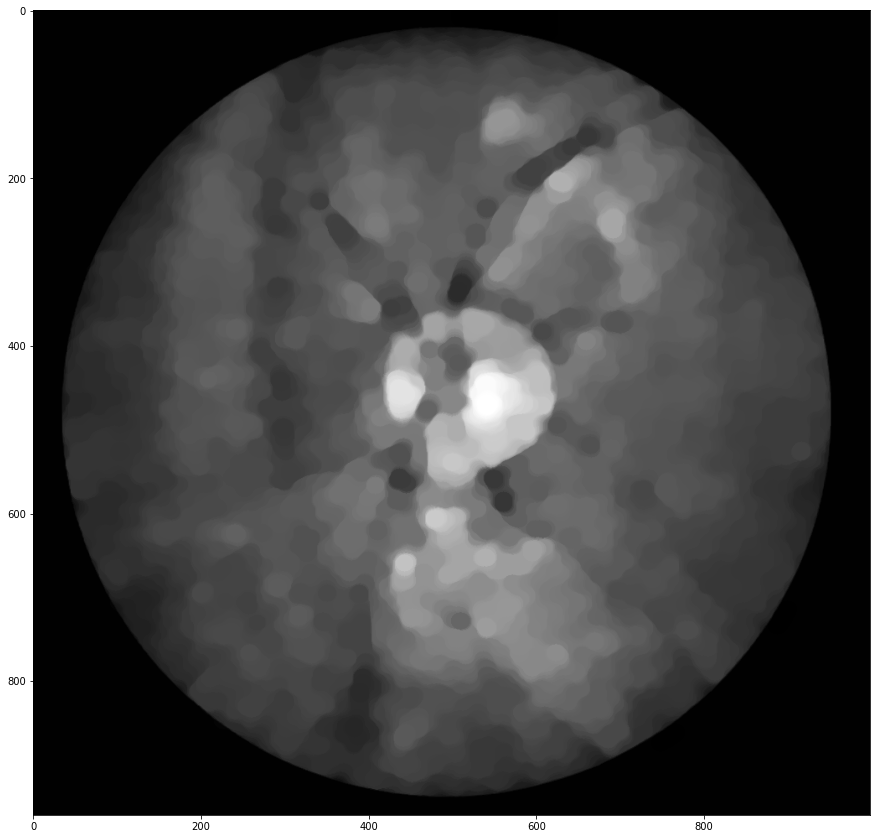

In [10]:
kernelSizes = [7, 11, 13, 21]
kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernelSizes]

morphology_steps = [imgEqualizedCLAHE.copy()]
for kernel in kernels:
    imageOpened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
    imageClosed = cv2.morphologyEx(imageOpened, cv2.MORPH_CLOSE, kernel, iterations = 1)
    morphology_steps.extend([imageOpened, imageClosed])

img = morphology_steps[-1]

fig = plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')
plt.show()

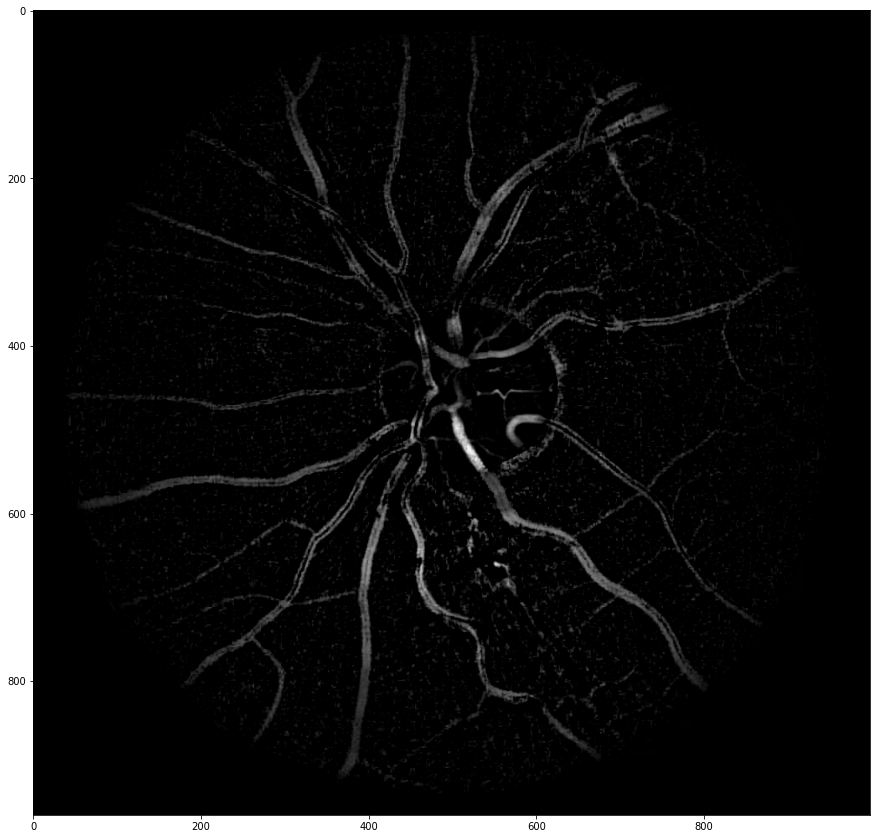

In [11]:
vessels = cv2.subtract(morphology_steps[-1],imgEqualizedCLAHE)

fig = plt.figure(figsize=(15, 15))
plt.imshow(vessels, cmap='gray')
plt.show()

Text(0.5, 1.0, 'Histogram obrazu poddanego wyrównaniu')

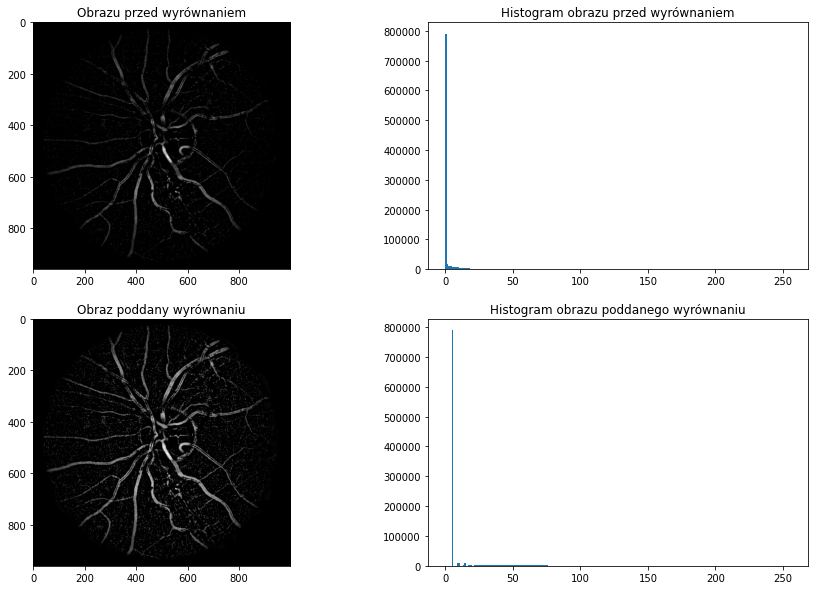

In [16]:
vesselsCLAHE = clahe.apply(vessels)
fig = plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(vessels, cmap='gray')
plt.title("Obrazu przed wyrównaniem")
plt.subplot(222)
plt.hist(vessels.ravel(),256,[0,256])
plt.title("Histogram obrazu przed wyrównaniem")

plt.subplot(223)
plt.imshow(vesselsCLAHE, cmap='gray')
plt.title("Obraz poddany wyrównaniu")
plt.subplot(224)
plt.hist(vesselsCLAHE.ravel(),256,[0,256])
plt.title("Histogram obrazu poddanego wyrównaniu")


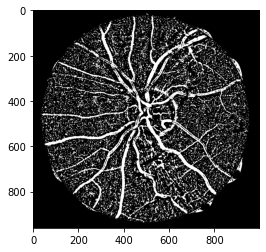

In [30]:
ret,vesselsThreshold = cv2.threshold(vesselsCLAHE,5,255,cv2.THRESH_BINARY)
plt.imshow(vesselsThreshold,cmap='gray')

(960, 999)


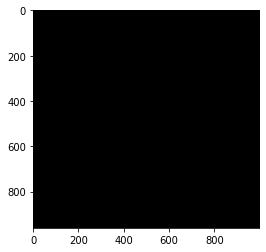

In [31]:
noise_mask = np.ones(vesselsThreshold.shape[:2], dtype="uint8") * 255
plt.imshow(noise_mask,cmap='gray')
print(np.shape(noise_mask))

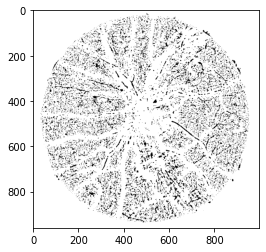

In [32]:
contours, hierarchy = cv2.findContours(vesselsThreshold.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    if cv2.contourArea(contour) <= 200:
        cv2.drawContours(noise_mask, [contour], -1, 0, -1)
plt.imshow(noise_mask, cmap='gray')

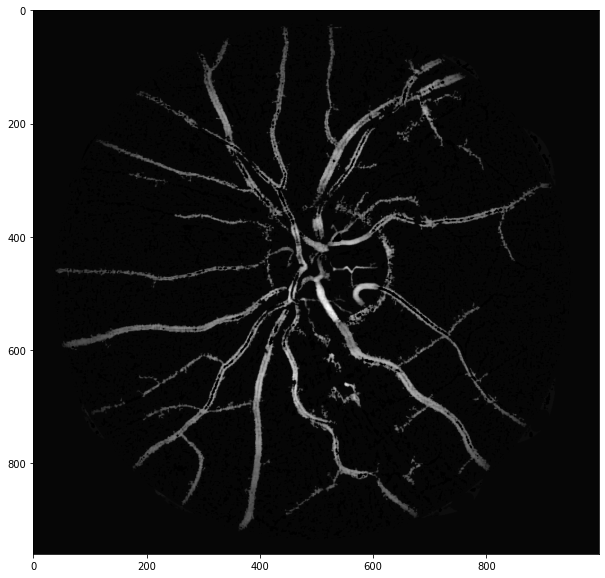

In [33]:
vesselsNoiseReducted = cv2.bitwise_and(vesselsCLAHE, vesselsCLAHE, mask=noise_mask)
fig = plt.figure(figsize=(15, 10))
plt.imshow(vesselsNoiseReducted, cmap='gray')

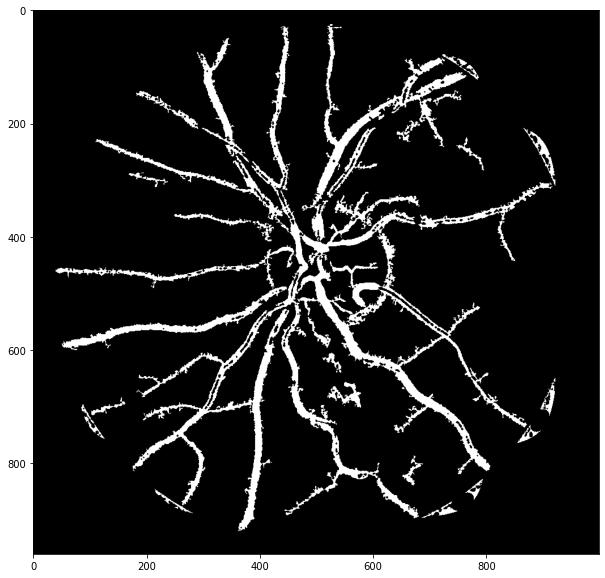

In [34]:
ret,vesselsThresholded = cv2.threshold(vesselsNoiseReducted,5,255,cv2.THRESH_BINARY)
fig = plt.figure(figsize=(15, 10))
plt.imshow(vesselsThresholded, cmap='gray')

## Now all of this steps for each img

In [35]:
def extractVessels(image, kernelSizes = [37, 49, 55, 73], threshold = 5, noiseContour = 1000):
    # extract green channel
    imageGreenChannel = image[:,:,1]
    
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    imageEqualizedCLAHE = clahe.apply(imageGreenChannel)
    
    # open-close to get background
    kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernelSizes]
    morphology_steps = [imageEqualizedCLAHE.copy()]
    for kernel in kernels:
        imageOpened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
        imageClosed = cv2.morphologyEx(imageOpened, cv2.MORPH_CLOSE, kernel, iterations = 1)
        morphology_steps.extend([imageOpened, imageClosed])
        
    # subtract vessels from background
    vessels = cv2.subtract(morphology_steps[-1],imageEqualizedCLAHE)

    # first threshold for contours
    _, vesselsThreshold = cv2.threshold(vessels,threshold,255,cv2.THRESH_BINARY)
    # get image noise
    
    noiseMask = np.ones(vesselsThreshold.shape[:2], dtype="uint8") * 255

    # delete noise in small contours
    contours, _ = cv2.findContours(vesselsThreshold.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= noiseContour: 
            cv2.drawContours(noiseMask, [contour], -1, 0, -1)
    vesselsNoiseReducted = cv2.bitwise_and(vessels, vessels, mask=noiseMask)
    
    # second threshold for result
    _, vesselsThresholded = cv2.threshold(vesselsNoiseReducted,threshold,255,cv2.THRESH_BINARY)
    return vesselsThresholded


In [36]:
imagesVessels = {}
for name, img in list(images.items())[0:6]:
    print(name)
    # imagesVessels[name] = extractVessels(img, kernelSizes = [37, 49, 55, 73], threshold = 5, noiseContour = 1000)
    imagesVessels[name] = extractVessels(img, kernelSizes =[7, 11, 13, 21], threshold = 5, noiseContour = 200)
    

01_h.jpg
02_h.jpg
03_h.jpg
04_h.jpg
05_h.jpg
06_h.jpg


(960, 999)
(960, 999, 3)


Text(0.5, 1.0, 'Manual')

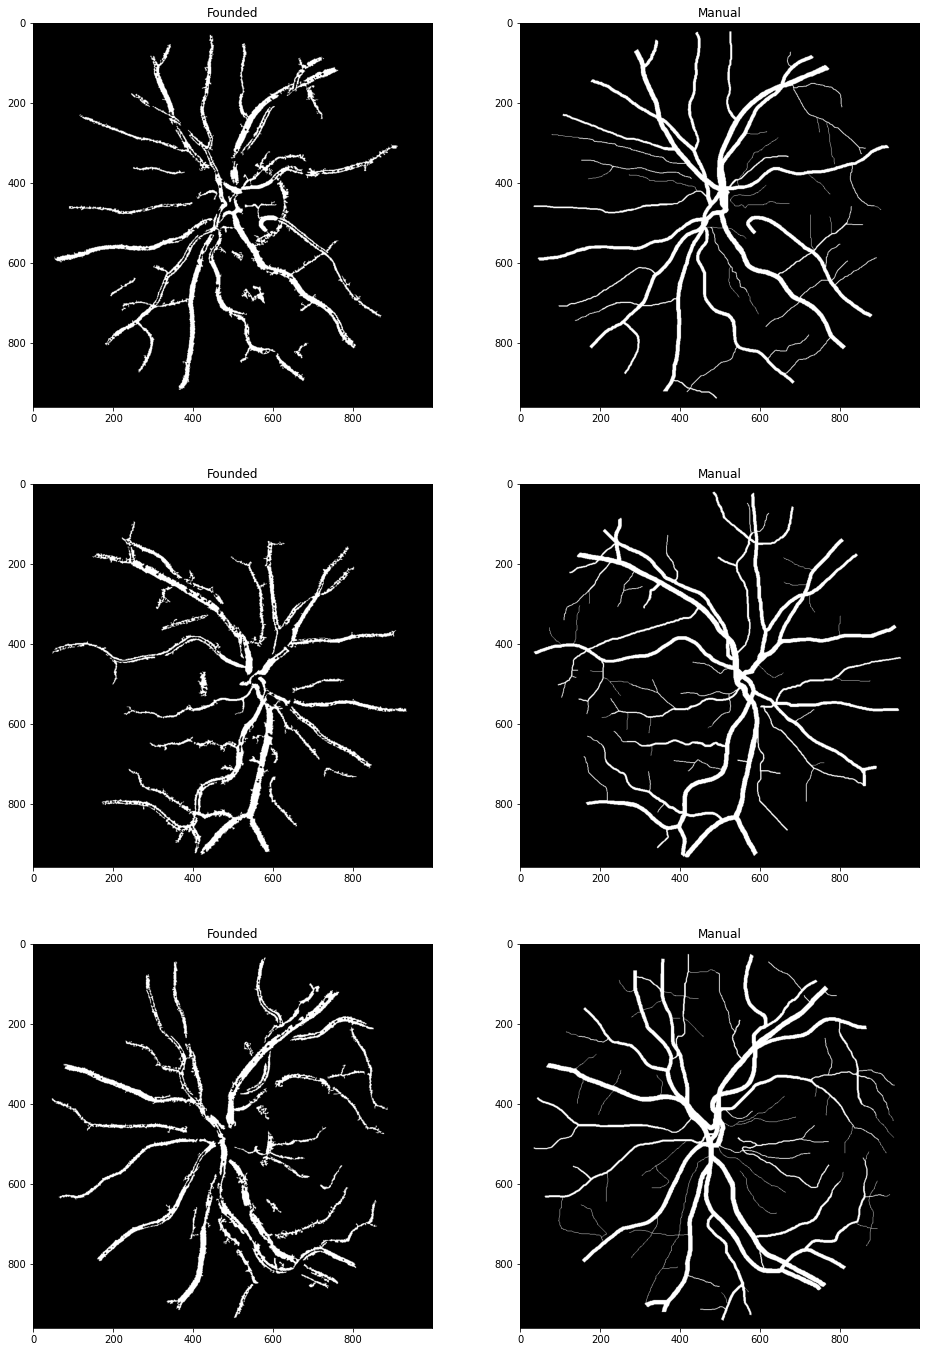

In [37]:
figure = plt.figure(figsize=(16,24))

name = '01_h.jpg'
plt.subplot(321)
plt.imshow(imagesVessels[name], cmap='gray')
print(np.shape(imagesVessels[name]))
plt.title("Founded")
plt.subplot(322)
plt.imshow(manualVessels[name], cmap='gray')
print(np.shape(manualVessels[name]))
plt.title("Manual")

name = '02_h.jpg'
plt.subplot(323)
plt.imshow(imagesVessels[name], cmap='gray')
plt.title("Founded")
plt.subplot(324)
plt.imshow(manualVessels[name], cmap='gray')
plt.title("Manual")

name = '03_h.jpg'
plt.subplot(325)
plt.imshow(imagesVessels[name], cmap='gray')
plt.title("Founded")
plt.subplot(326)
plt.imshow(manualVessels[name], cmap='gray')
plt.title("Manual")



Text(0.5, 1.0, 'Manual')

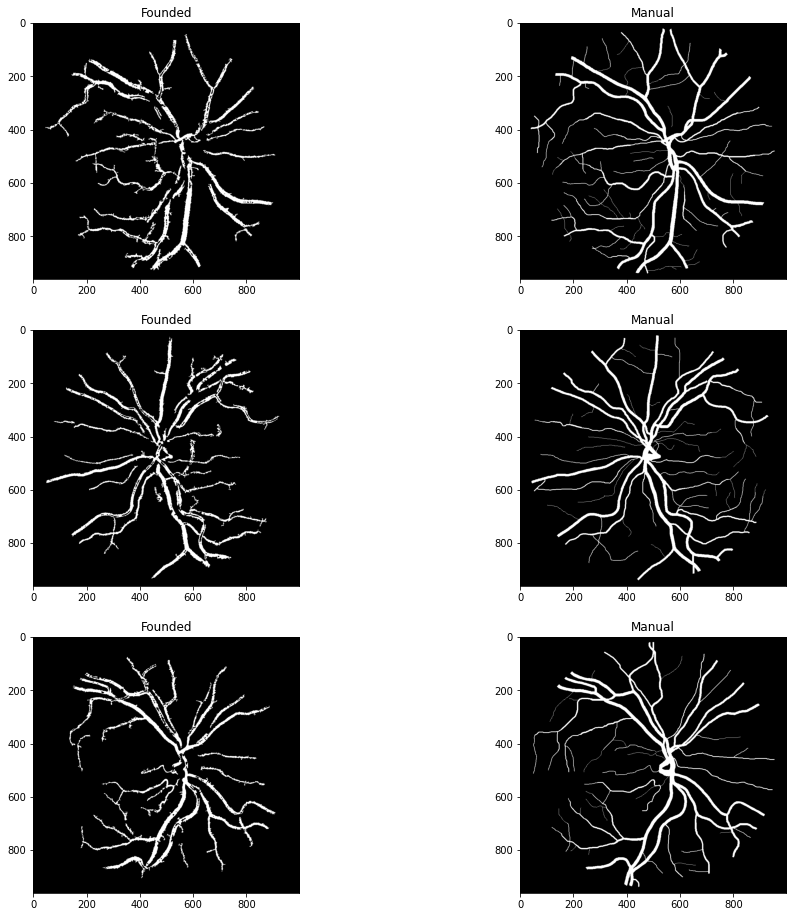

In [38]:
figure = plt.figure(figsize=(16,16))

name = '04_h.jpg'
plt.subplot(321)
plt.imshow(imagesVessels[name], cmap='gray')
plt.title("Founded")
plt.subplot(322)
plt.imshow(manualVessels[name], cmap='gray')
plt.title("Manual")

name = '05_h.jpg'
plt.subplot(323)
plt.imshow(imagesVessels[name], cmap='gray')
plt.title("Founded")
plt.subplot(324)
plt.imshow(manualVessels[name], cmap='gray')
plt.title("Manual")

name = '06_h.jpg'
plt.subplot(325)
plt.imshow(imagesVessels[name], cmap='gray')
plt.title("Founded")
plt.subplot(326)
plt.imshow(manualVessels[name], cmap='gray')
plt.title("Manual")

In [39]:
from sklearn.metrics import confusion_matrix


def summary(vesselsManual, vesselsFounded):
    conf = confusion_matrix(vesselsManual.flatten(), vesselsFounded.flatten())
    TrueNeg, FalsePos, FalseNeg, TruePos = conf.ravel()
    
    accuracy = (float (TruePos+TrueNeg) / float(TruePos + TrueNeg + FalsePos + FalseNeg))
    sensitivity = (TruePos / float(TruePos + FalseNeg))
    specificity = (TrueNeg / float(TrueNeg + FalsePos))
    geoMean = (sensitivity * specificity)**(1.0/2)
    
    return (accuracy, sensitivity, specificity, geoMean)

In [40]:
for name in imagesVessels.keys():
    print(name)
    vesselsFound = imagesVessels[name]
    vesselsManual = manualVessels[name][:,:,1]
    _, vesselsManual = cv2.threshold(vesselsManual,10,255,cv2.THRESH_BINARY)

    results = summary(vesselsManual,vesselsFound)
    print(f"accuracy: {round(results[0], 5)} sensitivity: {round(results[1], 5)} specificity: {round(results[2], 5)} geoMean: {round(results[3], 5)}")

01_h.jpg
accuracy: 0.9582 sensitivity: 0.65767 specificity: 0.98074 geoMean: 0.80312
02_h.jpg
accuracy: 0.9558 sensitivity: 0.60714 specificity: 0.98446 geoMean: 0.77311
03_h.jpg
accuracy: 0.95125 sensitivity: 0.60677 specificity: 0.98167 geoMean: 0.77178
04_h.jpg
accuracy: 0.94936 sensitivity: 0.6229 specificity: 0.97702 geoMean: 0.78012
05_h.jpg
accuracy: 0.95666 sensitivity: 0.68751 specificity: 0.97956 geoMean: 0.82065
06_h.jpg
accuracy: 0.95836 sensitivity: 0.67177 specificity: 0.98177 geoMean: 0.81211


# 2. Uczenie maszynowe

In [2]:
from skimage.util import view_as_windows
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from multiprocessing import Pool

In [111]:
imageFolder = "images"
imageNames = os.listdir(imageFolder)
imageNames.sort()
images = {}
for filename in imageNames:
    img = cv2.imread(imageFolder + "/" +  filename)
    images[filename] = img

manualLabeledImageFolder = "manual1"
labeledImageNames = os.listdir(manualLabeledImageFolder)
labeledImageNames.sort()
manualVessels = {}
for filename in labeledImageNames:
    img  = cv2.imread(manualLabeledImageFolder + "/" + filename)
    manualVessels[filename] = img

In [23]:
IMAGE_SHAPE = (999, 960, 3)
TILE_SHAPE = (5, 5, 3)


def imageFeatures(img, img_id):
    return np.array([tileFeatures(tile, img_id) for tile in imageToTiles(img)])

def imageTrainingValues(img):
    return np.array([tileTrainingValue(tile) for tile in imageToTiles(img)])

def tileFeatures(tile, img_id):
    channels = tile.reshape(-1,3)
    
    mean = np.mean(channels, axis=0)
    std = np.std(channels, axis=0)
    
    greenChannel = tile[:,:,1]
    centralMomentsKeys = ['mu20', 'mu11', 'mu02', 'mu30', 'mu21', 'mu12', 'mu03']
    
    moments = cv2.moments(greenChannel) 
    centralMoments = [moments[x] for x in centralMomentsKeys]
    huMoments = cv2.HuMoments(moments)[:,0]
    
    return np.hstack([img_id, mean, std, centralMoments, huMoments])

def tileTrainingValue(tile):
    tileMiddlePointIndex = len(tile)//2
    tileMiddlePoint = tile[tileMiddlePointIndex, tileMiddlePointIndex]
    if any(x > 0 for x in tileMiddlePoint):
        return True
    else:
        return False
    
def imageToTiles(img):
    tiles = []
    for i in range(0, IMAGE_SHAPE[1]-5):
        for j in range(0, IMAGE_SHAPE[0]-5):
            tiles.append(img[i:i+5, j:j+5])
            
    return tiles


# print(splitImage(images['01_h.jpg'], (5,5,3)))
# print(imageFeatures(images['01_h.jpg'])[0])
# print(imageTrainingValues(manualVessels['01_h.jpg']))

allImagesData = []

# for i, image in enumerate(images.values()):
#     allImagesData.append(imageFeatures(image, i))

with Pool() as pool:
    allImagesData = pool.starmap(imageFeatures, zip(images.values(), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]))
    
with Pool() as pool:
    allImagesTrainingValues = pool.map(imageTrainingValues, manualVessels.values())
    
# allImagesTrainingValues = []
# for image in manualVessels.values():
#     allImagesTrainingValues.append(imageTrainingValues(image))

print("Done")

Done


In [24]:
allImagesData = np.array(allImagesData).reshape(-1, 21)
allImagesTrainingValues = np.array(allImagesTrainingValues).reshape(-1)


print("Done")

Done


In [25]:
features = ['img_id', 'avg_r', 'avg_g', 'avg_b', 'std_r', 'std_g', 'std_b',
           'cm_1','cm_2','cm_3','cm_4','cm_5','cm_6',
           'cm_7','hm_1','hm_2','hm_3','hm_4','hm_5',
           'hm_6','hm_7']

df = pd.DataFrame(allImagesData, columns = features)
df['is_vessel'] = allImagesTrainingValues
df.head(5000000)

img_id  avg_r  avg_g   avg_b     std_r     std_g     std_b  \
0           0.0   0.00   0.00    0.00  0.000000  0.000000  0.000000   
1           0.0   0.00   0.00    0.00  0.000000  0.000000  0.000000   
2           0.0   0.00   0.00    0.00  0.000000  0.000000  0.000000   
3           0.0   0.00   0.00    0.00  0.000000  0.000000  0.000000   
4           0.0   0.00   0.00    0.00  0.000000  0.000000  0.000000   
...         ...    ...    ...     ...       ...       ...       ...   
4999995     5.0   2.52  39.24  142.04  1.472956  1.175755  1.708333   
4999996     5.0   2.96  39.40  142.64  1.038460  1.131371  1.162067   
4999997     5.0   3.00  39.56  142.92  0.894427  1.267438  1.197330   
4999998     5.0   2.88  39.88  143.60  0.765245  1.394848  1.697056   
4999999     5.0   3.04  40.32  144.40  0.823650  1.406272  1.939072   

                cm_1       cm_2         cm_3  ...       cm_6       cm_7  \
0           0.000000   0.000000     0.000000  ...   0.000000   0.000000   
1           0.000000   0.000000     0.000000  ...   0.000000   0.000000   
2           0.000000   0.000000     0.000000  ...   0.000000   0.000000   
3           0.000000   0.000000     0.000000  ...   0.000000   0.000000   
4           0.000000   0.000000     0.000000  ...   0.000000   0.000000   
...              ...        ...          ...  ...        ...        ...   
4999995  1957.983690 -27.032620  1991.934760  ...  21.318575 -34.732881   
4999996  1976.998985 -13.995939  2003.983756  ...  23.851810  -3.585919   
4999997  1985.801820  -5.900910  2018.950455  ...   3.336084  -0.130125   
4999998  1998.557673   6.147442  2038.950853  ...  -4.861520  -0.052847   
4999999  2017.329365  12.128968  2056.975198  ... -12.937213  -4.390127   

             hm_1          hm_2          hm_3          hm_4          hm_5  \
0        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...           ...           ...           ...           ...           ...   
4999995  0.004104  4.400772e-09  9.079326e-12  1.127439e-12  1.513383e-24   
4999996  0.004103  1.605933e-09  6.426963e-12  3.849430e-13 -6.013833e-25   
4999997  0.004094  1.294124e-09  3.080712e-12  1.123190e-12  1.971613e-24   
4999998  0.004062  1.804328e-09  2.728317e-12  4.018175e-12  1.317953e-23   
4999999  0.004010  2.092473e-09  9.481519e-13  6.653168e-12  1.614154e-23   

                 hm_6          hm_7  is_vessel  
0        0.000000e+00  0.000000e+00      False  
1        0.000000e+00  0.000000e+00      False  
2        0.000000e+00  0.000000e+00      False  
3        0.000000e+00  0.000000e+00      False  
4        0.000000e+00  0.000000e+00      False  
...               ...           ...        ...  
4999995  7.167321e-17 -3.274347e-24      False  
4999996 -8.774278e-18 -7.028720e-26      False  
4999997 -2.278728e-17  6.913789e-25      False  
4999998 -1.706627e-16 -1.817492e-24      False  
4999999 -2.386435e-16 -4.322219e-24      False  

[5000000 rows x 22 columns]

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(['is_vessel'], axis='columns'),allImagesTrainingValues, test_size=0.2)

In [27]:
undersampler = RandomUnderSampler(sampling_strategy=1, random_state=1)
x_train, y_train = undersampler.fit_resample(x_train, y_train)

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

RandomForestClassifier()

In [28]:
classifier.score(x_train,y_train)

0.9999841140520287

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


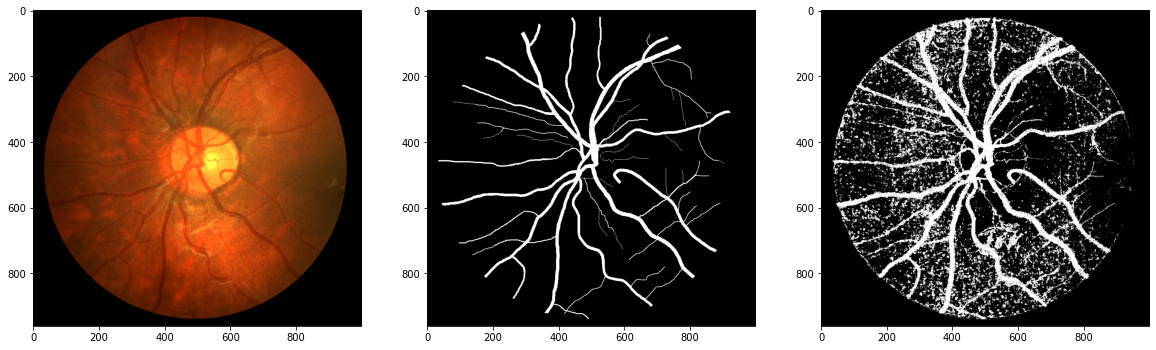

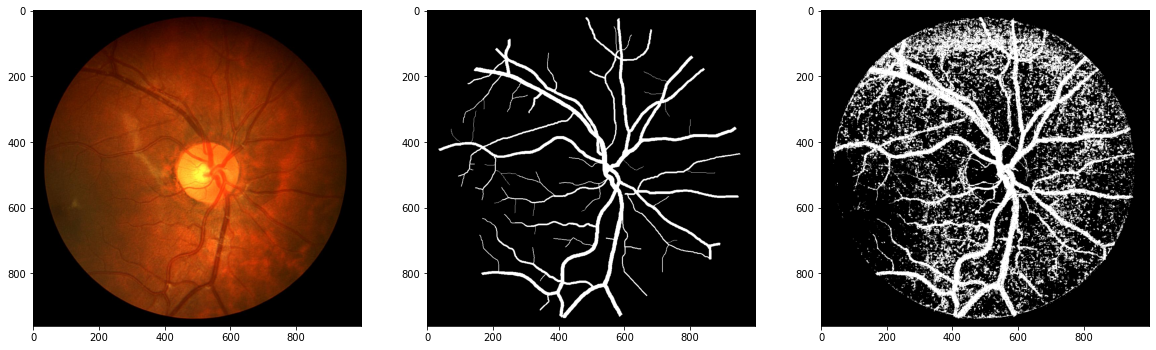

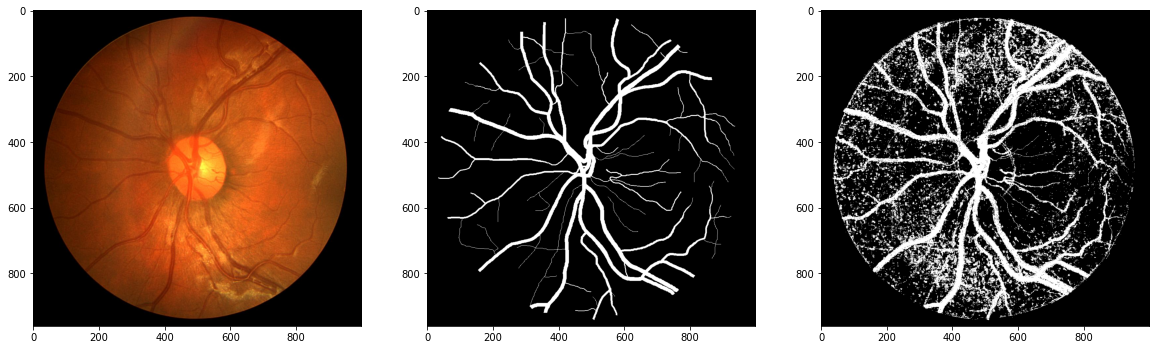

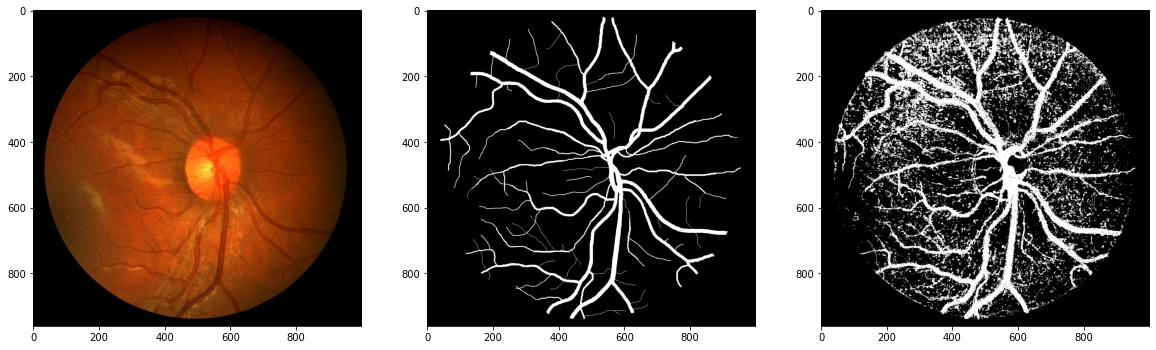

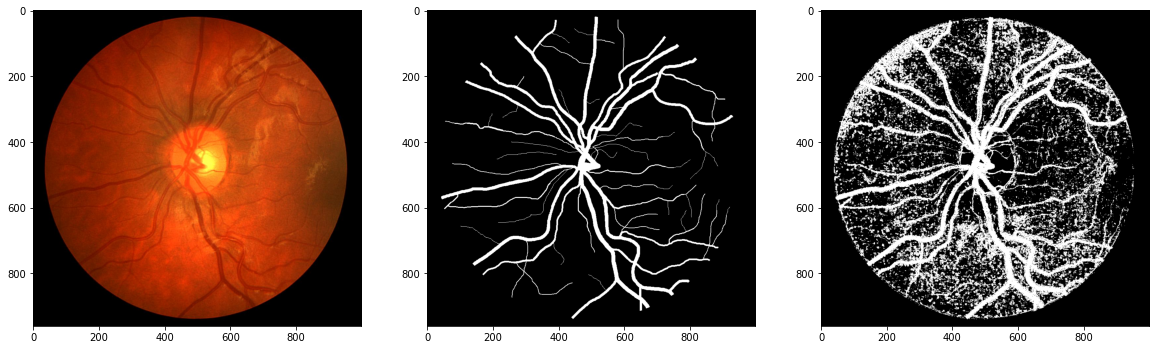

In [161]:

predictedImages = {}


for i, imageKey in enumerate(images.keys()):
    imageDf = df[df.img_id == i]
    x_train, y_train = imageDf[features], df.is_vessel
    Y = classifier.predict_proba(x_train)[:,1] > 0.5
    
    originalImage = images[imageKey][:,:,::-1]
    manualImage = manualVessels[imageKey]
    
    mask = np.pad(Y.reshape(955, 994), 2)
    mask = np.pad(mask, ((1,0), (1,0)))
    mask = np.dstack([mask] * 3)
    
    predictedImage = np.broadcast_to([1.0,1.0,1.0], originalImage.shape)
    predictedImage = mask*(predictedImage + originalImage)
    predictedImages[imageKey] = predictedImage
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,100))
    ax1.imshow(originalImage)
    ax2.imshow(manualImage)
    ax3.imshow(predictedImage, cmap='gray')
    if i == 4:
        break

In [162]:
from sklearn.metrics import confusion_matrix


def summary(vesselsManual, vesselsFound):
    conf = confusion_matrix(vesselsManual.flatten(), vesselsFound.flatten())
    TrueNeg, FalsePos, FalseNeg, TruePos = conf.ravel()
    
    accuracy = (float (TruePos+TrueNeg) / float(TruePos + TrueNeg + FalsePos + FalseNeg))
    sensitivity = (TruePos / float(TruePos + FalseNeg))
    specificity = (TrueNeg / float(TrueNeg + FalsePos))
    geoMean = (sensitivity * specificity)**(1.0/2)
    
    return (accuracy, sensitivity, specificity, geoMean)

In [163]:
for i, name in enumerate(predictedImages.keys()):
    print(name)
    vesselsFound = predictedImages[name]
    vesselsManual = manualVessels[name][:,:,1]
    _, vesselsManual = cv2.threshold(vesselsManual,10,255,cv2.THRESH_BINARY)
    _, vesselsFound = cv2.threshold(vesselsFound,10,255,cv2.THRESH_BINARY)

    results = summary(vesselsManual,vesselsFound)
    print(f"accuracy: {results[0]} sensitivity: {results[1]} specificity: {results[2]} geoMean: {results[3]}")
    if i==4:
        break

01_h.jpg


ValueError: Found input variables with inconsistent numbers of samples: [959040, 2877120]